# Full Demo
---
In this notebook we will run everything and discuss every option/variation on the different phases of our pipeline. These variations will require modifications to some underlying scripts, but such modifications will be explained in detail


### 0. Env Setup & Repo Structure 

To build out our environment, run the following -- if working in pronto, we advise looking at [their documentation on conda environments](https://research.it.iastate.edu/guides/pronto/conda/).
```bash
conda env create -f environment.yml
conda activate neurox_pip
```

While all subsequent steps allow you the option to specify your own output file location, our logic also generates default output directories for everything in an organized way. `Data/{datasetname}/` should contain your starting parallel corpus. Every preprocessing step will by default place its output file in that same `Data/{datasetname}/` directory, and print the name of the created output file to the console.

`Experiments/{model}/{datasetname}/{layer}/` will contain the results of the activation extraction and alignment and overlap calculations. In addition these leaf directories will also contain a `config.txt` which contains a full log of the experiment parameters for reproduce-ability.

There are a lot of modifications necessary if you plan to save things to bespoke output locations instead of where we have specified.

### 1. Data Preprocessing (Code tokenization and alignment)

In this section, we observe and modify a code dataset, stored in `Data/` that contains a parallel corpus of format `entire_function_in_language_one(...){....} ||| entire_function_in_language_two(...){...} \n second_function_in_language_one(...){...} ||| ...`. By the end, you will have all of the files necessary to run the actual activation extractions and COLAP/CALIGN calculations.

**NOTE:** Depending on proposed changes to our analysis steps, the entire preprocessing pipeline may have to be modified to accomodate a very different approach that does not deal directly with tokens at all. 

---

#### 1.1 Tokenize Dataset

Our first step here deals with tokenization schemes. Our alignments are supposed to be at the word level, so we need to insert a delimiter (space) between each "word" of code. What we define as a "word" of code can have pretty significant downstream affects. The baseline we have settled with is using the leaves of the Tree-Sitter parsing tree, which looks like this: 
```bash
!python -u tree/sitter/tokenize_corpus.py <input_corpus> <left_language_name> <right_language_name> --level [leaf, line]
```

**Note:** that the language names can be finnicky, and need to match the name of the specific tree sitter parser you've installed inside of the `tree-sitter/` directory for your language. Additionally, the parsing levels are a bit naive still, and could serve from some serious upgrading.


In [18]:
!python -u tree-sitter/tokenize_corpus.py Data/Java-CS/java-cs.txt java c-sharp --level leaf

/work/instruction/coms-599-29-f24/group_4_clustering/.conda/envs/neurox_pip/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language.build_library is deprecated. Use the new bindings instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/work/instruction/coms-599-29-f24/group_4_clustering/.conda/envs/neurox_pip/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
Traceback (most recent call last):
  File "tree-sitter/tokenize_corpus.py", line 87, in <module>
    main()
  File "tree-sitter/tokenize_corpus.py", line 72, in main
    LEFT_LANGUAGE = Language('build/my-languages.so', f'{args.left_lang}')
  File "/work/instruction/coms-599-29-f24/group_4_clustering/.conda/envs/neurox_pip/lib/python3.8/site-packages/tree_sitter/__init__.py", line 133, in __init__
    language_fun

#### Notes
We are looking into other tokenization options at this time, including [COMEX](https://www.youtube.com/watch?v=GER6U87FVbU). The idea being that we may need to be looking at activations at higher levels than individual tokens. If we could be comparing lines of code or even entire coding functions, we could probably derive better insights. Just gotta figure out how to do that...

---

#### 1.2. Collect Alignments 
This step will generate a Pharaoh Format output for each sentence in the tokenized corpus using either fast-align or Awesome-Align. In either case, we use the alignment to generate our translation dictionary, which is used to compute alignment between clusters.

`!./fast_align/build/fast_align -i {input_corpus} -d -o -v > {outputfile.align}`

**NOTE**: you must fully specify the output path for this command.


##### Fast-Align

In [20]:
! ./fast_align/build/fast_align -i Data/Java-CS/tree_sitter_tokenized_leaf.txt -d -o -v > Data/Java-CS/forward.align

ARG=i
ARG=d
ARG=o
ARG=v
INITIAL PASS 
..........
expected target length = source length * 0.839762
ITERATION 1
..........
  log_e likelihood: -8.27393e+06
  log_2 likelihood: -1.19368e+07
     cross entropy: 29.8974
        perplexity: 1e+09
      posterior p0: 0.08
 posterior al-feat: -0.164379
       size counts: 2323
ITERATION 2
..........
  log_e likelihood: -1.86466e+06
  log_2 likelihood: -2.69014e+06
     cross entropy: 6.73784
        perplexity: 106.731
      posterior p0: 0.0550538
 posterior al-feat: -0.137115
       size counts: 2323
  1  model al-feat: -0.209484 (tension=4)
  2  model al-feat: -0.171489 (tension=5.44738)
  3  model al-feat: -0.157254 (tension=6.13486)
  4  model al-feat: -0.149839 (tension=6.53763)
  5  model al-feat: -0.145468 (tension=6.79209)
  6  model al-feat: -0.142721 (tension=6.95914)
  7  model al-feat: -0.14093 (tension=7.07126)
  8  model al-feat: -0.139734 (tension=7.14755)
     final tension: 7.19993
ITERATION 3
..........
  log_e likelihood: 

#### Notes
Not really sure we are gunna do alignments long term. They're kinda a weird way to get a dictionary in the context of looking at code.

---

#### 1.3 Create Translation Dictionary

This sorta has two parts. `! python -u utils/wordlevel_dict.py` gives you the `json` file that our later scripts expect. `! python -u utils/wordlevel_dict_text.py` gives you the human readable `.txt` that can be used to actually check the quality of the dictionary. Their functionality is virtually the same.

These dicts are located in the same directory as your `text_file` input argument.

In [1]:
! python -u utils/wordlevel_dict.py -h

usage: wordlevel_dict.py [-h] [--output_file OUTPUT_FILE]
                         text_file alignment_file

Generate a word-level dictionary from text and alignment files.

positional arguments:
  text_file             Path to the text input file.
  alignment_file        Path to the alignment input file.

optional arguments:
  -h, --help            show this help message and exit
  --output_file OUTPUT_FILE
                        Path to the output dictionary json file. (Default:
                        <text_file_directory>/dictionary.json


In [21]:
! python -u utils/wordlevel_dict.py Data/Java-CS/tree_sitter_tokenized_leaf.txt Data/Java-CS/forward.align

Data/Java-CS/dictionary.json created successfully.


In [5]:
! python -u utils/wordlevel_dict_text.py Data/EN-DE/en_de.txt Data/EN-DE/forward.align

Data/EN-DE/dictionary.txt created successfully.


#### Notes:
See earlier notes on alignments vs. line/function level analysis. Everything up to now may wind up being irrelevant

---

#### 1.4 Make Mapping Dict
This dictionary structure is required by the script that performs calculation of the $CALIGN$ metric

In [22]:
! python -u utils/mapping_fastalign.py Data/Java-CS/tree_sitter_tokenized_leaf.txt Data/Java-CS/forward.align

Saved mapping_dict to Data/Java-CS/mapping_dict.json


---

#### 1.5 Split Corpus Into Encoder and Decoder Pieces
Our standard `|||` delimited corpus has the input and output of our transformer in the same file. The following steps require separate encoder and decoder input files. This script just splits the corpus up into two files using the delimiter.

By default, this script outputs the encoder and input files to the same directory as your `input_file`.

In [7]:
! python -u utils/split.py -h

usage: split.py [-h] [--output_dir OUTPUT_DIR] input_file

Split a file into two parts based on '|||' delimiter.

positional arguments:
  input_file            Path to the input file.

optional arguments:
  -h, --help            show this help message and exit
  --output_dir OUTPUT_DIR
                        Directory where the output files will be saved.


In [8]:
! python -u utils/split.py Data/EN-DE/en_de.txt

Encoder input saved to Data/EN-DE/input.in
Decoder input saved to Data/EN-DE/label.out


### 2. Analysis
In this step we run the activation extractions, compute the alignment and overlap, and do visualizations. This is where the fun begins.

---
#### 2.1 Activation Extractions

The analysis pipeline is formatted as a number of bash scripts. These each require a fair amount of modification to run different experiments with. Bare with me.

To extract the activations, we are going to rely on a modified version of the [NeuroX library](https://github.com/fdalvi/NeuroX). The modified version is included in this repository.

##### Running Activation Extraction For Concept Alignment Experiment

In [ ]:
import os
os.environ['HF_HOME'] = '/work/instruction/coms-599-29-f24/group_4_clustering/Cross-Lingual-Code-Concept-Analysis/cache/'

In [9]:
! ./utils_qcri/activation_extraction_with_filtering_2.sh --model google-t5/t5-base  --inputPath Data/EN-DE --layer 3

[INFO] encoder filtered file is saved as: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_with_filtering/input.in.tok.sent_len
[INFO] decoder filtered file is saved as: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_with_filtering/label.out.tok.sent_len
[INFO] Number of skipped lines: 0
USING GPU WOOHOO
Loading model: google-t5/t5-base
Reading input corpus
Preparing output files
Extracting representations from model
Processing sentences: 0sentence [00:00, ?sentence/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing sentences: 300sentence [00:14, 21.17sentence/s]
Loading activations...
Loading json activations from Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_with_filtering/encoder-activations-layer3.json...
300 1.0
Loading tokens...
Preparing dataset...
300it [00:00, 3048.30it/s]
Writing datasets...
Loading activations...
Loading json activations f

##### Running Activation Extraction For Overlap Experiment

In [10]:
! ./utils_qcri/activation_extraction_without_filtering_2.sh --model google-t5/t5-base  --inputPath Data/EN-DE --layer 3

[INFO] encoder filtered file is saved as: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/input.in.tok.sent_len
[INFO] decoder filtered file is saved as: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/label.out.tok.sent_len
[INFO] Number of skipped lines: 0
Reading file:  Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/input.in.tok.sent_len
Saving output file
######### Singletons #############
['apples', 'drives', 'bright', 'reads', 'mathematics', 'better', 'My', 'cook', 'cold', 'snowy,', 'Our', 'sings', 'beautifully', 'becoming', 'known', 'buildings', 'vibrant', 'nightlife', 'solving', 'puzzles', 'group', 'fruits', "farmers'", 'yesterday', 'airplane', 'flew', 'mountains,', 'offering', 'breathtaking', 'preparing', 'mark', 'anniversary', 'stayed', 'until', 'end', 'knitting', 'scarf', 'as', 'gift', 'barked', 'loudly', 'saw', 'squirrel', 'add', 'menu', 'train', 'journey', 'filled', 'spends', 'nearby', 

##### Clustering Representations

In [26]:
! ./utils_qcri/clustering_2.sh --inputPath Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering --clusters 500 --mode visualize

Preparing for visualize
outputDir: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/clustering
clusters: 500
USAGE: create_kmeans_clustering.py -p <POINT_FILE> -v <VOCAB_FILE> -k <CLUSTERS> -o <OUTPUT_FOLDER>
Initialization complete
Iteration 0, inertia 575749550.3232726
Iteration 1, inertia 354569540.2854599
Iteration 2, inertia 351819440.33973163
Iteration 3, inertia 351330664.96123827
Iteration 4, inertia 351064797.55530643
Iteration 5, inertia 351054367.0154285
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 573809598.5854796
Iteration 1, inertia 353423465.47359437
Iteration 2, inertia 351160279.8937559
Iteration 3, inertia 350683805.8640098
Iteration 4, inertia 350578992.33088714
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 585652095.467576
Iteration 1, inertia 357289818.6854157
Iteration 2, inertia 354943408.8996779
Iteration 3, inertia 354240193.7505292
Iteration 

##### Aligning Clusters

In [54]:
! utils_qcri/get_alignment_2.sh -h

Usage: utils_qcri/get_alignment_2.sh [options]

Options:
  --top_n_translations <int>   Number of top translations to consider. (default: 5)
  --matching_threshold <float> Matching threshold for semantic alignment. (default: 0.6)
  --size_threshold <float>     Size difference threshold for alignment. (default: 0.4)
  --types <int>                Minimal distinct word size. (default: 1)
  --clusterDir <path>          Directory containing encoder and decoder cluster files. (required)
  --dictionary <path>          Path to the dictionary file. (required)
  -h, --help                   Display this help message and exit.

Example:
  bash utils_qcri/get_alignment_2.sh --clusterDir clusters --dictionary Dictionary/en-fr.json --top_n_translations 10


In [53]:
! utils_qcri/get_alignment_2.sh --clusterDir Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/clustering --dictionary Data/EN-DE/dictionary.json

Encoder cluster file: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/clustering/encoder-clusters-kmeans-500.txt
Decoder cluster file: Experiments/google-t5_t5-base/Data_EN-DE/layer3/extraction_without_filtering/clustering/decoder-clusters-kmeans-500.txt
{('town', 'Stadt'), ('city', 'Stadt')}
Source Cluster 10 Target Cluster 74
Source Cluster Size 3 Target Cluster Size 2
2 3
{('children', 'Kinder'), ('kids', 'Kinder')}
Source Cluster 15 Target Cluster 58
Source Cluster Size 2 Target Cluster Size 2
2 2
{('class', 'teil,'), ('course', 'teil,')}
Source Cluster 27 Target Cluster 304
Source Cluster Size 2 Target Cluster Size 2
2 2
{('studied', 'studierte'), ('studying', 'studiert')}
Source Cluster 212 Target Cluster 330
Source Cluster Size 3 Target Cluster Size 2
2 3
{('but', 'aber'), ('or', 'oder'), ('and', 'und')}
Source Cluster 224 Target Cluster 408
Source Cluster Size 3 Target Cluster Size 2
2 3
{('Our', 'Unsere'), ('our', 'unsere'), ('us', 'uns')}
Source C

##### Get Cluster Overlaps: THERE ARE APPARENT ERRORS IN THE OVERLAP CODE

In [ ]:
# ! utils_qcri/get_overlap_2.sh 

##### Visualization

Is a bit tricky, and may need to be handled elsewhere

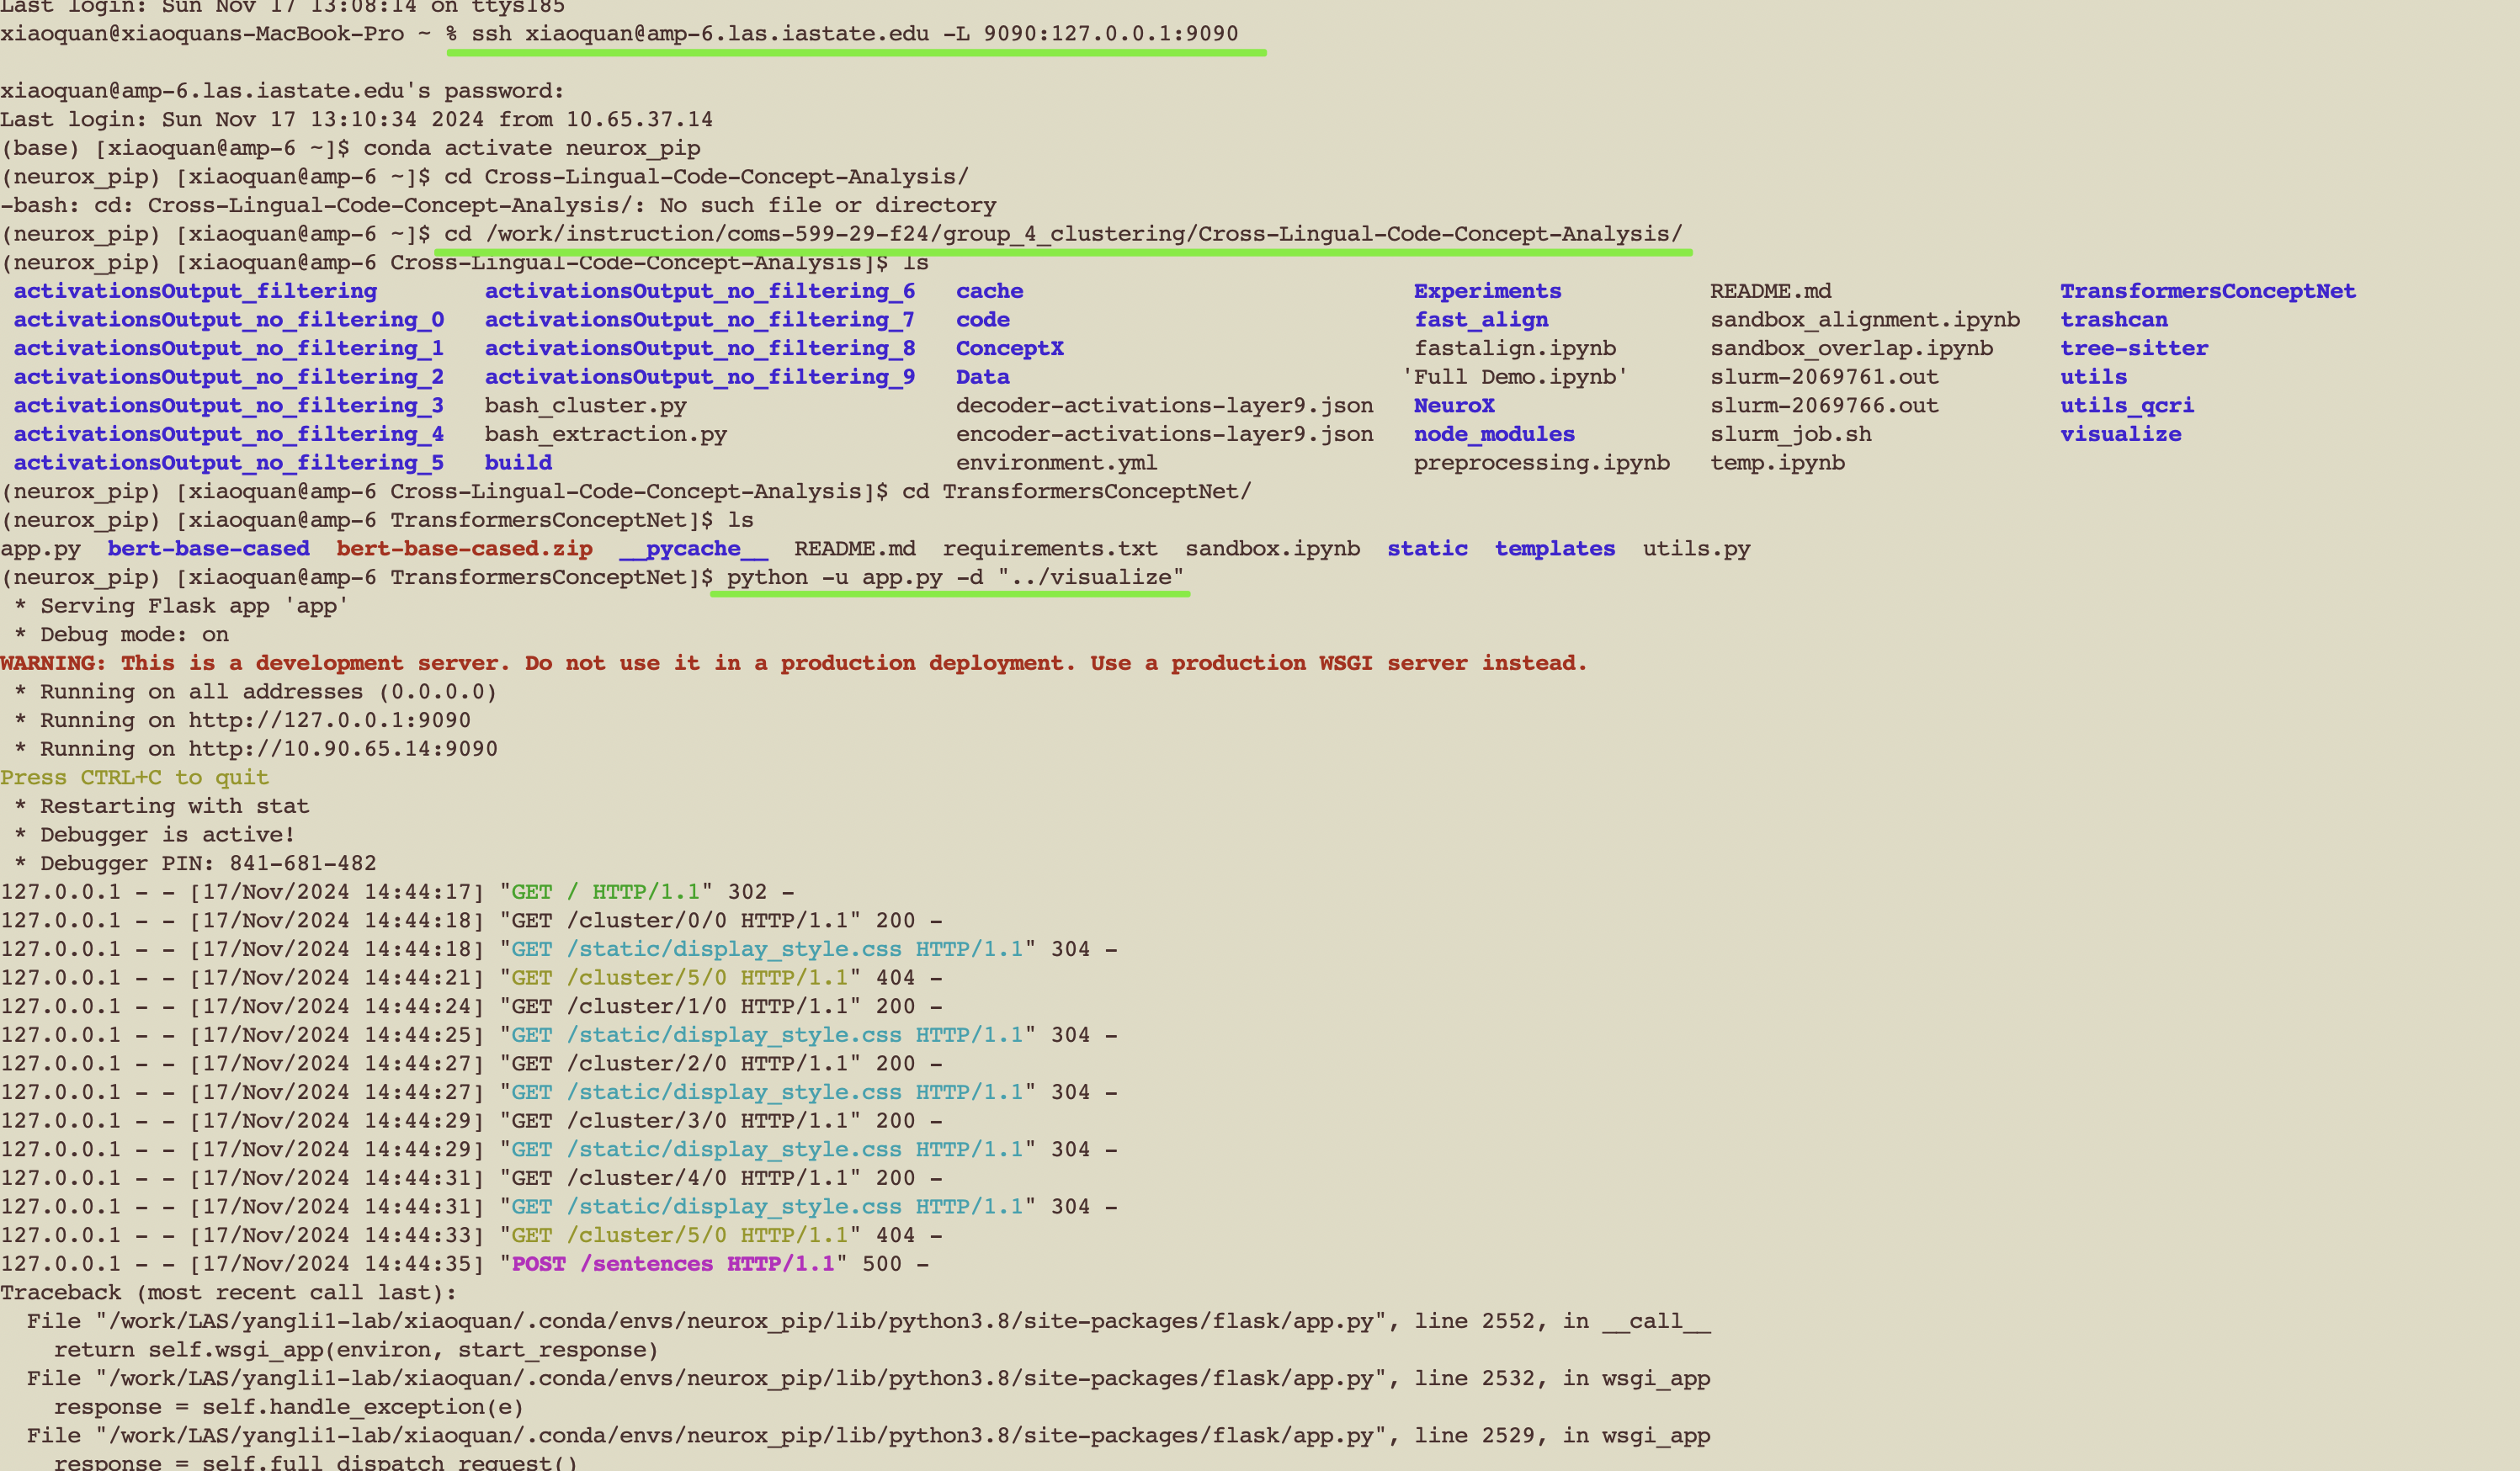